# ImportPackages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Initialization Parameters


In [2]:
batch_size=100
learning_rate = 0.001

If the GPU is available use it for the computation otherwise use the CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are 2 ways to load the Fashion MNIST dataset.
1. Load csv and then inherite Pytorch Dataset class .
2. Use Pytorch module torchvision.datasets. It has many popular datasets like MNIST, FashionMNIST, CIFAR10 e.t.c.
We use DataLoader class from torch.utils.data to load data in batches in both method.
Comment out the code of a method which you are not using

# Load Data

## 1. Using FashionMNIST class from torchvision module

In [4]:
train_dataset = torchvision.datasets.FashionMNIST("./FashionMNIST",train=True,transform=torchvision.transforms.Compose([transforms.ToTensor()]),target_transform=None,download=True)
test_dataset= torchvision.datasets.FashionMNIST("./FashionMNIST",train=False,transform=torchvision.transforms.Compose([transforms.ToTensor()]),target_transform=None,download=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 118831597.28it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4988711.77it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 57669782.50it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12096513.72it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

## 2. Using a Dataset class

* First load the data from the disk using pandas read_csv() method.
* Now inherit Dataset class in your own class that you are building, lets say FashionData.
    * It has 2 methods: get_item( ) and len().
    * get_item( ) return the images and labels and len( ) returns the number of items in a dataset.


In [6]:
# train_csv = pd.read_csv("../input/fashion-mnist_train.csv")
# test_csv = pd.read_csv("../input/fashion-mnist_test.csv")

In [7]:
# class FashionDataset(Dataset):
#     """User defined class to build a datset using Pytorch class Dataset."""
    
#     def __init__(self, data, transform = None):
#         """Method to initilaize variables.""" 
#         self.fashion_MNIST = list(data.values)
#         self.transform = transform
        
#         label = []
#         image = []
        
#         for i in self.fashion_MNIST:
#              # first column is of labels.
#             label.append(i[0])
#             image.append(i[1:])
#         self.labels = np.asarray(label)
#         # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
#         self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

#     def __getitem__(self, index):
#         label = self.labels[index]
#         image = self.images[index]
        
#         if self.transform is not None:
#             image = self.transform(image)

#         return image, label

#     def __len__(self):
#         return len(self.images)

In [8]:
# train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
# test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

## We have 10 types of clothes in FashionMNIST dataset.

Making a method that return the name of class for the label number. ex. if the label is 5, we return Sandal.


In [9]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

# Show Some Samples

Playing with data and displaying some images using matplotlib imshow() method.¶

In [10]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [11]:
len(train_dataset)

60000

9


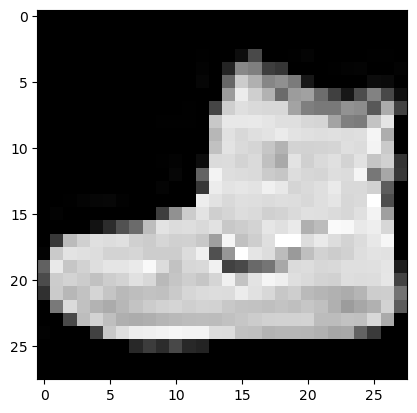

In [12]:
image, label = next(iter(train_dataset))
plt.imshow(image.squeeze(), cmap="gray")
print(label)



In [13]:
demo_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

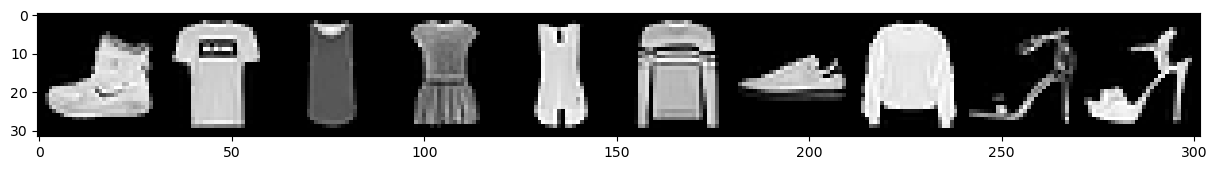

In [14]:


grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")



# Building a CNN


* Make a model class (FashionCNN in our case)
    *It inherit nn.Module class that is a super class for all the neural networks in Pytorch.

* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
            * Flatten out the output for dense layer(a.k.a. fully connected layer).
            * 3 Fully connected layer with different in/out features.
            * 1 Dropout layer that has class probability p = 0.25.
        * All the functionaltiy is given in forward method that defines the forward pass of CNN.
        * Our input image is changing in a following way:
            * First Convulation layer : input: 28 * 28 * 3, output: 28 * 28 * 32
            * First Max Pooling layer : input: 28 * 28 * 32, output: 14 * 14 * 32
            * Second Conv layer : input : 14 * 14 * 32, output: 12 * 12 * 64
            * Second Max Pooling layer : 12 * 12 * 64, output: 6 * 6 * 64
    * Final fully connected layer has 10 output features for 10 types of clothes.


In [15]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

Making a model of our CNN class
* Creating a object(model in the code)
* Transfering it into GPU if available.
* Defining a Loss function. we're using CrossEntropyLoss() here.
* Using Adam algorithm for optimization purpose.


In [16]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Training a network and Testing it on test dataset

In [17]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data.detach().cpu())
            iteration_list.append(count)
            accuracy_list.append(accuracy.detach().cpu())
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.2821924686431885, Accuracy: 85.2699966430664%
Iteration: 1000, Loss: 0.34798359870910645, Accuracy: 87.45999908447266%
Iteration: 1500, Loss: 0.22218389809131622, Accuracy: 88.37999725341797%
Iteration: 2000, Loss: 0.31054988503456116, Accuracy: 89.79000091552734%
Iteration: 2500, Loss: 0.159319669008255, Accuracy: 90.70999908447266%
Iteration: 3000, Loss: 0.2664334774017334, Accuracy: 89.97000122070312%
Iteration: 3500, Loss: 0.2683866024017334, Accuracy: 91.0%
Iteration: 4000, Loss: 0.13194361329078674, Accuracy: 91.18000030517578%
Iteration: 4500, Loss: 0.28543606400489807, Accuracy: 91.5199966430664%
Iteration: 5000, Loss: 0.15910488367080688, Accuracy: 90.54000091552734%
Iteration: 5500, Loss: 0.1366577297449112, Accuracy: 91.19999694824219%
Iteration: 6000, Loss: 0.1216447725892067, Accuracy: 91.81999969482422%



## Visualizing the Loss and Accuracy with Iterations


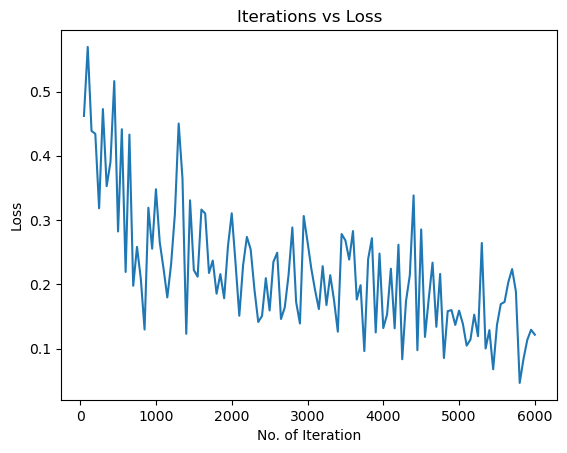

In [18]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

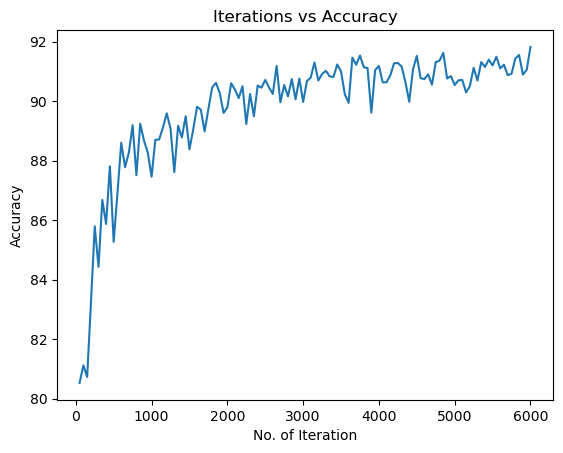

In [19]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

## Printing the Confusion Matrix

In [20]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))



In [21]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))



Classification report for CNN :
              precision    recall  f1-score   support

           0       0.84      0.85      0.84    120000
           1       0.99      0.98      0.98    120000
           2       0.84      0.85      0.85    120000
           3       0.90      0.90      0.90    120000
           4       0.83      0.84      0.84    120000
           5       0.97      0.97      0.97    120000
           6       0.72      0.70      0.71    120000
           7       0.94      0.95      0.95    120000
           8       0.98      0.98      0.98    120000
           9       0.97      0.96      0.96    120000

    accuracy                           0.90   1200000
   macro avg       0.90      0.90      0.90   1200000
weighted avg       0.90      0.90      0.90   1200000


